# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):
  with open(file_path, 'r') as file:
    data = json.load(file)
  return pd.DataFrame(data)




##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
df=load_json_dataframe('/content/ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [8]:
# print the dimensions of dataframe - df
display(Markdown("### Dimensions of the DataFrame:"))
display(Markdown(f"**Rows:** {df.shape[0]}, **Columns:** {df.shape[1]}"))
# print the column names of dataframe - df
display(Markdown("### Column Names:"))
display(Markdown(f"**Columns:** {', '.join(df.columns)}"))

### Dimensions of the DataFrame:

**Rows:** 285, **Columns:** 2

### Column Names:

**Columns:** input, pos

In [9]:
# print the information of the dataframe
display(Markdown("### DataFrame Information:"))
df.info()

### DataFrame Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())
# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [11]:
# display first five rows of the dataframe - df
display(Markdown("### First five rows of the DataFrame:"))
display(df.head())

### First five rows of the DataFrame:

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [13]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df['input_length'] != df['pos_length']]
print(f"Number of rows with unequal input_length and pos_length: {len(unequal_rows)}")

if len(unequal_rows) > 0:
    print("\nRows with unequal lengths:")
    display(unequal_rows[['input_length', 'pos_length']])
    print(f"\nIndexes of unequal rows: {unequal_rows.index.tolist()}")
else:
    print("All rows have equal input_length and pos_length")



Number of rows with unequal input_length and pos_length: 5

Rows with unequal lengths:


,input_length,pos_length
17,15,14
27,37,36
79,38,37
164,54,53
207,18,17



Indexes of unequal rows: [17, 27, 79, 164, 207]


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
  # Flatten the list of pos_tokens into one long list
  all_labels = [label for sublist in df['pos_tokens'] for label in sublist]
  # Use set to get unique lables
  unique = set(all_labels)
  print(f"Unique POS lables found in the dataset: {sorted(unique)}")
  return unique

  for label in labels:
    unique_labels.update(label)
  return unique_labels
unique_pos_tags = unique_labels(df)

Unique POS lables found in the dataset: ['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [15]:
# Get indexes where input and POS lengths don't match
mismatched_indexes = df[df['input_length'] != df['pos_length']].index.tolist()

# Print results
print(f"Total mismatched rows: {len(mismatched_indexes)}")
print("Indexes needing cleaning:", mismatched_indexes)

Total mismatched rows: 5
Indexes needing cleaning: [17, 27, 79, 164, 207]


<div style="background-color:#ffffff; border:1px solid #dcdcdc; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Problematic Rows Identified:</h3>
    <ul>
        <li>Index 17: <strong>input_length = 15</strong>, <strong>pos_length = 14</strong> (missing 1 POS label)</li>
        <li>Index 27: <strong>input_length = 37</strong>, <strong>pos_length = 36</strong> (missing 1 POS label)</li>
        <li>Index 79: <strong>input_length = 38</strong>, <strong>pos_length = 37</strong> (missing 1 POS label)</li>
        <li>Index 164: <strong>input_length = 54</strong>, <strong>pos_length = 53</strong> (missing 1 POS label)</li>
        <li>Index 207: <strong>input_length = 18</strong>, <strong>pos_length = 17</strong> (missing 1 POS label)</li>
    </ul>
</div>

<div style="background-color:#ffffff; border:1px solid #dcdcdc; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Key Issues:</h3>
    <ul>
        <li>All problematic rows have <strong>fewer POS labels</strong> than input tokens</li>
        <li>This causes <strong>misalignment</strong> between tokens and their corresponding labels</li>
        <li>Such misalignment will cause <strong>training errors</strong> in the CRF model</li>
        <li>The data integrity is <strong>compromised</strong> for proper sequence labeling</li>
    </ul>
</div>

<div style="background-color:#ffffff; border:1px solid #dcdcdc; padding:15px; border-radius:6px;">
    <h3>Required Action:</h3>
    <div style="background-color:#fff3cd; border-left:5px solid #ffc107; padding:10px; margin-top:10px;">
        These 5 rows (<strong>indexes: 17, 27, 79, 164, 207</strong>) need to be <strong>dropped</strong> from the dataset to ensure:
    </div>
    <ul>
        <li>Perfect alignment between input tokens and POS labels</li>
        <li>Clean training data for the CRF model</li>
        <li>Reliable sequence labeling performance</li>
    </ul>
</div>
"""

display(HTML(html_content))


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [16]:
# drop the irrelevant recipe data
df = df.drop(unequal_rows.index)
print(f"Dropped {len(unequal_rows)} rows with misaligned data")
print(f"Remaining rows in dataframe: {len(df)}")

# Reset index to maintain sequential indexing
df = df.reset_index(drop=True)
print("Index reset successfully")


Dropped 5 rows with misaligned data
Remaining rows in dataframe: 280
Index reset successfully


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [17]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [18]:
# validate the input length and pos length as input_length and pos_length
# check for the equality of input_length and pos_length in the dataframe after cleaning

unequal_rows_after_cleaning = df[df['input_length'] != df['pos_length']]
print(f"Number of rows with unequal input_length and pos_length after cleaning: {len(unequal_rows_after_cleaning)}")

if len(unequal_rows_after_cleaning) > 0:
    print("\nRows with unequal lengths:")
    display(unequal_rows_after_cleaning[['input_length', 'pos_length']])
    print(f"\nIndexes of unequal rows: {unequal_rows_after_cleaning.index.tolist()}")
else:
    print("All rows have equal input_length and pos_length")
    print("Data validation successful - ready for CRF training")




Number of rows with unequal input_length and pos_length after cleaning: 0
All rows have equal input_length and pos_length
Data validation successful - ready for CRF training


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [19]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)
# Reset index to maintain sequential indexing
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training set size: {len(train_df)} rows")
print(f"Validation set size: {len(val_df)} rows")
print(f"Training ratio: {len(train_df)/len(df):.1%}")
print(f"Validation ratio: {len(val_df)/len(df):.1%}")

Training set size: 196 rows
Validation set size: 84 rows
Training ratio: 70.0%
Validation ratio: 30.0%


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [20]:
# print the first five rows of train_df
display(Markdown("### First five rows of the Training DataFrame:"))
display(train_df.head())

### First five rows of the Training DataFrame:

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41
2,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25
3,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, 

In [21]:
# print the first five rows of the val_df
display(Markdown("### First five rows of the Validation DataFrame:"))
display(val_df.head())


### First five rows of the Validation DataFrame:

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15
1,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56
2,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35
3,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingredient quantity ingredient ingredie

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [22]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

print(f"X_train length: {len(X_train)}")
print(f"X_val length: {len(X_val)}")
print(f"y_train length: {len(y_train)}")
print(f"y_val length: {len(y_val)}")

X_train length: 196
X_val length: 84
y_train length: 196
y_val length: 84


In [23]:
# validate the shape of training and validation samples
print("Training dataset validation:")
print(f"Training samples (X_train): {len(X_train)}")
print(f"Training labels (y_train): {len(y_train)}")
print(f"Training dataframe shape: {train_df.shape}")

print("\nValidation dataset validation:")
print(f"Validation samples (X_val): {len(X_val)}")
print(f"Validation labels (y_val): {len(y_val)}")
print(f"Validation dataframe shape: {val_df.shape}")

print("\nDataset split validation:")
print(f"Total original samples: {len(df)}")
print(f"Training + Validation samples: {len(X_train) + len(X_val)}")
print(f"Split verification: {len(X_train) + len(X_val) == len(df)}")

print("\nSample length validation:")
print(f"X_train sample lengths match y_train: {len(X_train) == len(y_train)}")
print(f"X_val sample lengths match y_val: {len(X_val) == len(y_val)}")

Training dataset validation:
Training samples (X_train): 196
Training labels (y_train): 196
Training dataframe shape: (196, 6)

Validation dataset validation:
Validation samples (X_val): 84
Validation labels (y_val): 84
Validation dataframe shape: (84, 6)

Dataset split validation:
Total original samples: 280
Training + Validation samples: 280
Split verification: True

Sample length validation:
X_train sample lengths match y_train: True
X_val sample lengths match y_val: True


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [24]:
# Display the number of unique labels present in y_train
all_labels_train = []
for labels in y_train:
    all_labels_train.extend(labels)

unique_labels_train = set(all_labels_train)
print(f"Number of unique labels in y_train: {len(unique_labels_train)}")
print(f"Unique labels: {sorted(unique_labels_train)}")

# Count frequency of each label
label_counts = Counter(all_labels_train)
print(f"\nLabel distribution in y_train:")
for label, count in label_counts.most_common():
    print(f"  {label}: {count}")

Number of unique labels in y_train: 3
Unique labels: ['ingredient', 'quantity', 'unit']

Label distribution in y_train:
  ingredient: 5323
  quantity: 980
  unit: 811


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [25]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flatten a nested list structure into a single flat list

    Parameters:
    nested_list (list): A nested list structure

    Returns:
    list: A flattened list containing all elements from the nested structure
    """
    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend(item)
        else:
            flattened.append(item)
    return flattened

In [26]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [27]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
def extract_and_validate_tokens(df, dataset_name):
    """
    Extract and validate tokens from dataframe

    Parameters:
    df (pd.DataFrame): DataFrame containing input_tokens and pos_tokens
    dataset_name (str): Name of the dataset (Training/Validation)

    Returns:
    tuple: Flattened input tokens and pos tokens
    """
    # Flatten the input_tokens and pos_tokens using the flatten_list function
    input_tokens_flat = flatten_list(df['input_tokens'].tolist())
    pos_tokens_flat = flatten_list(df['pos_tokens'].tolist())

    # Validate their length
    print(f"=== {dataset_name} Dataset Token Validation ===")
    print(f"Total input tokens: {len(input_tokens_flat)}")
    print(f"Total POS tokens: {len(pos_tokens_flat)}")
    print(f"Lengths match: {len(input_tokens_flat) == len(pos_tokens_flat)}")

    # Display first 10 records
    print(f"\nFirst 10 input tokens: {input_tokens_flat[:10]}")
    print(f"First 10 POS tokens: {pos_tokens_flat[:10]}")

    return input_tokens_flat, pos_tokens_flat



In [28]:
# extract the tokens and its pos tags
#train_df
input_tokens_flat_train, pos_tokens_flat_train = extract_and_validate_tokens(train_df, 'Training')

print("\n")  # Print a newline for better readability
print("--" * 80)  # Separator for clarity
print("\n")  # Print a newline for better readability
#val_df
input_tokens_flat_val, pos_tokens_flat_val = extract_and_validate_tokens(val_df, 'Validation')

=== Training Dataset Token Validation ===
Total input tokens: 7114
Total POS tokens: 7114
Lengths match: True

First 10 input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


----------------------------------------------------------------------------------------------------------------------------------------------------------------


=== Validation Dataset Token Validation ===
Total input tokens: 2876
Total POS tokens: 2876
Lengths match: True

First 10 input tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 POS tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [29]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units and quantities based on their POS tags

    Parameters:
    tokens (list): List of input tokens
    pos_tags (list): List of corresponding POS tags

    Returns:
    tuple: Three lists (ingredients, units, quantities)
    """
    # Validate input lengths
    if len(tokens) != len(pos_tags):
        print(f"Warning: Length mismatch - tokens: {len(tokens)}, pos_tags: {len(pos_tags)}")
        return [], [], []

    # Initialize lists
    ingredients = []
    units = []
    quantities = []

    # Categorize tokens based on their POS tags
    for token, pos_tag in zip(tokens, pos_tags):
        if pos_tag == 'ingredient':
            ingredients.append(token)
        elif pos_tag == 'unit':
            units.append(token)
        elif pos_tag == 'quantity':
            quantities.append(token)
        else:
            print(f"Warning: Unknown POS tag '{pos_tag}' for token '{token}'")

    # Validate that we only have expected labels
    expected_labels = {'ingredient', 'unit', 'quantity'}
    found_labels = set(pos_tags)

    if not found_labels.issubset(expected_labels):
        unexpected_labels = found_labels - expected_labels
        print(f"Warning: Found unexpected labels: {unexpected_labels}")
        return [], [], []

    return ingredients, units, quantities




In [30]:
#  call the function to categorise the labels into respective list
ingredients_train, units_train, quantities_train = categorize_tokens(input_tokens_flat_train, pos_tokens_flat_train)

print(f"Training dataset categorization:")
print(f"Number of ingredients: {len(ingredients_train)}")
print(f"Number of units: {len(units_train)}")
print(f"Number of quantities: {len(quantities_train)}")

print(f"\nFirst 10 ingredients: {ingredients_train[:10]}")
print(f"First 10 units: {units_train[:10]}")
print(f"First 10 quantities: {quantities_train[:10]}")


Training dataset categorization:
Number of ingredients: 5323
Number of units: 811
Number of quantities: 980

First 10 ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
First 10 units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
First 10 quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [31]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, label, dataset_name, top_n=10):
    """
    Get top N most frequent items from a list

    Parameters:
    item_list (list): List of items to analyze
    label (str): Label for the type of items (e.g., 'ingredient', 'unit', 'quantity')
    dataset_name (str): Name of the dataset (Training/Validation)
    top_n (int): Number of top items to return (default: 10)

    Returns:
    list: List of tuples containing (item, frequency) for top N items
    """
    # Count frequency of each item
    item_counts = Counter(item_list)

    # Get top N most frequent items
    top_items = item_counts.most_common(top_n)

    print(f"=== Top {top_n} Most Frequent {label.title()}s in {dataset_name} Dataset ===")
    print(f"Total unique {label}s: {len(item_counts)}")
    print(f"Total {label} occurrences: {sum(item_counts.values())}")
    print()

    for i, (item, count) in enumerate(top_items, 1):
        print(f"{i:2d}. {item:<20} : {count:4d} occurrences")

    return top_items

In [32]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients_train = get_top_frequent_items(ingredients_train, 'ingredient', dataset_name)

=== Top 10 Most Frequent Ingredients in Training Dataset ===
Total unique ingredients: 836
Total ingredient occurrences: 5323

 1. powder               :  129 occurrences
 2. Salt                 :  102 occurrences
 3. seeds                :   89 occurrences
 4. Green                :   85 occurrences
 5. chopped              :   84 occurrences
 6. Oil                  :   83 occurrences
 7. Red                  :   81 occurrences
 8. Chilli               :   77 occurrences
 9. Coriander            :   71 occurrences
10. Sunflower            :   65 occurrences


In [33]:
# get the top units which are frequently seen in the recipe
top_units_train = get_top_frequent_items(units_train, 'unit', dataset_name)

=== Top 10 Most Frequent Units in Training Dataset ===
Total unique units: 45
Total unit occurrences: 811

 1. teaspoon             :  162 occurrences
 2. cup                  :  136 occurrences
 3. tablespoon           :   99 occurrences
 4. grams                :   63 occurrences
 5. tablespoons          :   61 occurrences
 6. inch                 :   52 occurrences
 7. cups                 :   50 occurrences
 8. sprig                :   41 occurrences
 9. cloves               :   39 occurrences
10. teaspoons            :   39 occurrences


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [34]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    """
    Plot a bar graph for top 10 most frequent items

    Parameters:
    top_items (list): List of tuples containing (item, frequency) for top items
    label (str): Label for the type of items (e.g., 'ingredient', 'unit')
    dataset_name (str): Name of the dataset (Training/Validation)

    Returns:
    None
    """
    # Extract items and frequencies
    items = [item[0] for item in top_items]
    frequencies = [item[1] for item in top_items]

    # Create the plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(items, frequencies, color='skyblue', edgecolor='navy', alpha=0.7)

    # Customize the plot
    plt.title(f'Top 10 Most Frequent {label.title()}s in {dataset_name} Dataset',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(f'{label.title()}s', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add value labels on top of bars
    for bar, freq in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{freq}', ha='center', va='bottom', fontweight='bold')

    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Display the plot
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



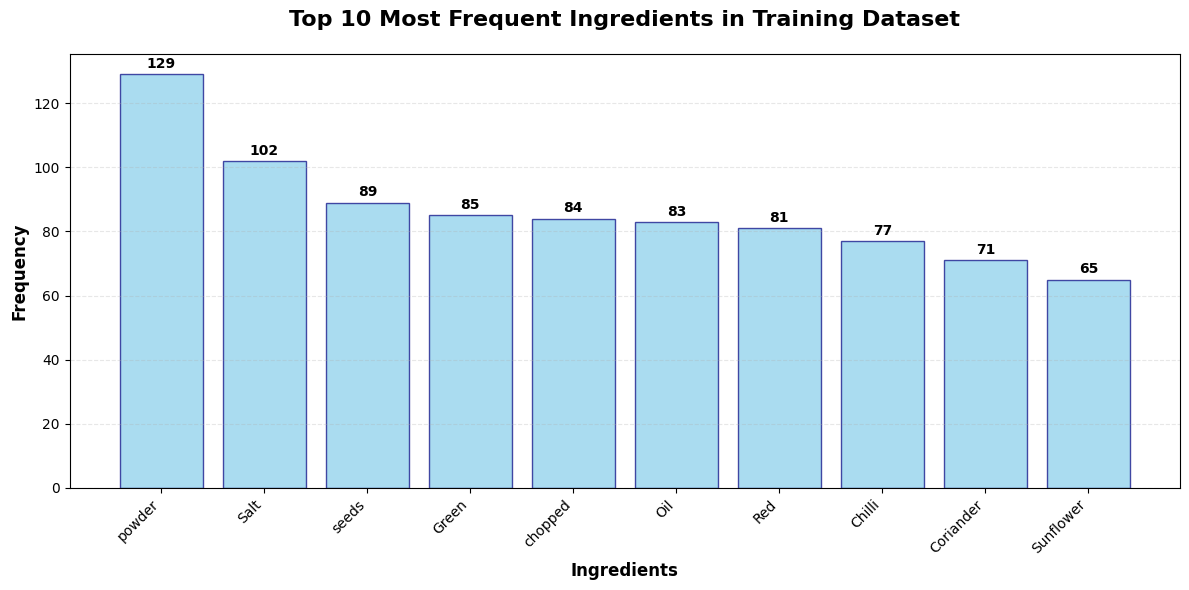

In [35]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients_train, 'ingredient', dataset_name)

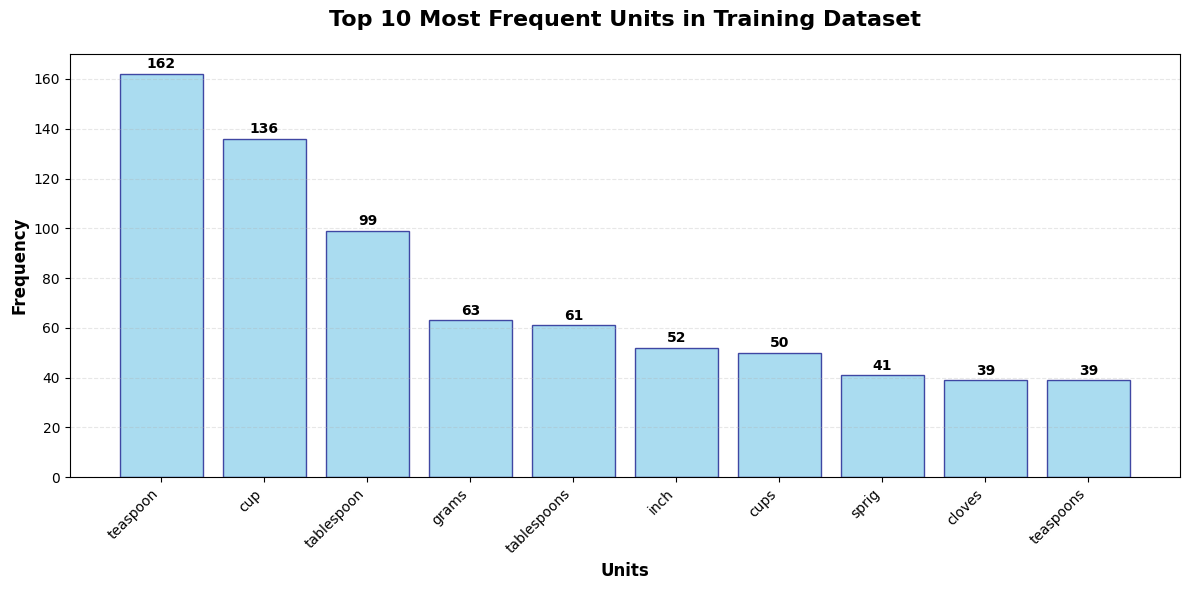

In [36]:
# plot the top frequent units in training data
plot_top_items(top_units_train, 'unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [37]:
# initialise the dataset_name


In [38]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [39]:
# plot the top frequent ingredients in validation data


In [40]:
# plot the top frequent units in training data



## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [41]:

# define unit and quantity keywords along with quantity pattern

# Unit keywords - common measurement units
unit_keywords = {
    'cup', 'cups', 'tablespoon', 'tablespoons', 'tbsp', 'teaspoon', 'teaspoons', 'tsp',
    'gram', 'grams', 'gm', 'gms', 'kg', 'kilogram', 'kilograms', 'pound', 'pounds', 'lb', 'lbs',
    'ounce', 'ounces', 'oz', 'liter', 'liters', 'litre', 'litres', 'ml', 'milliliter', 'milliliters',
    'pint', 'pints', 'quart', 'quarts', 'gallon', 'gallons', 'inch', 'inches', 'cm', 'centimeter',
    'piece', 'pieces', 'slice', 'slices', 'clove', 'cloves', 'bunch', 'bunches', 'sprig', 'sprigs',
    'pinch', 'pinches', 'dash', 'dashes', 'drop', 'drops', 'handful', 'handfuls', 'stick', 'sticks',
    'can', 'cans', 'jar', 'jars', 'bottle', 'bottles', 'pack', 'packs', 'packet', 'packets',
    'bowl', 'bowls', 'plate', 'plates', 'glass', 'glasses', 'mug', 'mugs', 'scoop', 'scoops',
    'unit', 'units', 'whole', 'halves', 'quarters', 'thirds', 'pod', 'pods', 'leaf', 'leaves'
}

# Quantity keywords - quantity descriptors
quantity_keywords = {
    'half', 'quarter', 'third', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
    'nine', 'ten', 'dozen', 'few', 'some', 'little', 'small', 'medium', 'large', 'big', 'tiny',
    'handful', 'pinch', 'dash', 'splash', 'drizzle', 'generous', 'heaping', 'level', 'rounded',
    'packed', 'loose', 'fresh', 'dried', 'ground', 'whole', 'chopped', 'sliced', 'diced'
}

# Regex pattern for quantity - matches fractions, decimals, whole numbers, and ranges
quantity_pattern = re.compile(r'''
    \b(?:
        \d+(?:[/-]\d+)*(?:\.\d+)?  |  # Fractions like 1/2, 2-1/2, decimals like 3.5
        \d+\.\d+                   |  # Decimal numbers like 2.5, 1.25
        \d+                        |  # Whole numbers like 1, 10, 250
        \d+-\d+                       # Ranges like 8-10, 3-4
    )\b
''', re.VERBOSE)

print("Unit keywords defined:", len(unit_keywords), "units")
print("Quantity keywords defined:", len(quantity_keywords), "keywords")
print("Quantity pattern created for fractions, decimals, and numbers")



Unit keywords defined: 89 units
Quantity keywords defined: 40 keywords
Quantity pattern created for fractions, decimals, and numbers


In [42]:
# load spaCy model
nlp = spacy.load('en_core_web_sm')

print("spaCy model loaded successfully")
print(f"Model name: {nlp.meta['name']}")
print(f"Model version: {nlp.meta['version']}")

spaCy model loaded successfully
Model name: core_web_sm
Model version: 3.8.0


In [43]:
sentence = "Add 1 1/2 cups of flour and 2 tablespoons sugar."
doc = nlp(sentence)

for token in doc:
    token_lower = token.text.lower()
    is_quantity = bool(quantity_pattern.fullmatch(token.text)) or token_lower in quantity_keywords
    is_unit = token_lower in unit_keywords
    print(f"{token.text:<12} | Quantity: {is_quantity:<5} | Unit: {is_unit}")



Add          | Quantity: 0     | Unit: False
1            | Quantity: 1     | Unit: False
1/2          | Quantity: 1     | Unit: False
cups         | Quantity: 0     | Unit: True
of           | Quantity: 0     | Unit: False
flour        | Quantity: 0     | Unit: False
and          | Quantity: 0     | Unit: False
2            | Quantity: 1     | Unit: False
tablespoons  | Quantity: 0     | Unit: True
sugar        | Quantity: 0     | Unit: False
.            | Quantity: 0     | Unit: False


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [44]:
def word2features(sent, i):
    """
    Extract features for a single token in a sentence

    Parameters:
    sent (list): List of tokens in the sentence
    i (int): Index of the current token

    Returns:
    dict: Dictionary of features for the token
    """
    # Process the entire sentence with spaCy
    doc = nlp(' '.join(sent))

    # Get the current token
    token = sent[i]
    spacy_token = doc[i] if i < len(doc) else None

    # Initialize features dictionary
    features = {}

    # --- Core Features ---
    features['bias'] = 1.0
    features['token'] = token.lower()
    features['lemma'] = spacy_token.lemma_.lower() if spacy_token else token.lower()
    features['pos_tag'] = spacy_token.pos_ if spacy_token else 'UNKNOWN'
    features['tag'] = spacy_token.tag_ if spacy_token else 'UNKNOWN'
    features['dep'] = spacy_token.dep_ if spacy_token else 'UNKNOWN'
    features['shape'] = spacy_token.shape_ if spacy_token else token
    features['is_stop'] = spacy_token.is_stop if spacy_token else False
    features['is_digit'] = token.isdigit()
    features['has_digit'] = bool(re.search(r'\d', token))
    features['has_alpha'] = bool(re.search(r'[a-zA-Z]', token))
    features['hyphenated'] = '-' in token
    features['slash_present'] = '/' in token
    features['is_title'] = token.istitle()
    features['is_upper'] = token.isupper()
    features['is_punct'] = spacy_token.is_punct if spacy_token else False

    # --- Improved Quantity & Unit Detection ---
    features['is_quantity'] = bool(quantity_pattern.match(token)) or token.lower() in quantity_keywords
    features['is_unit'] = token.lower() in unit_keywords
    features['is_numeric'] = bool(re.match(r'^\d+$', token))
    features['is_fraction'] = bool(re.match(r'^\d+[/-]\d+', token))
    features['is_decimal'] = bool(re.match(r'^\d*\.\d+$', token))
    features['preceding_word'] = sent[i-1] if i > 0 else '<BOS>'
    features['following_word'] = sent[i+1] if i < len(sent)-1 else '<EOS>'

    # --- Contextual Features ---
    if i > 0:
        prev_token = sent[i-1]
        features['prev_token'] = prev_token.lower()
        features['prev_is_quantity'] = bool(quantity_pattern.match(prev_token)) or prev_token.lower() in quantity_keywords
        features['prev_is_digit'] = prev_token.isdigit()
        features['BOS'] = False
    else:
        features['prev_token'] = '<BOS>'
        features['prev_is_quantity'] = False
        features['prev_is_digit'] = False
        features['BOS'] = True

    if i < len(sent) - 1:
        next_token = sent[i+1]
        features['next_token'] = next_token.lower()
        features['next_is_unit'] = next_token.lower() in unit_keywords
        features['next_is_ingredient'] = not (next_token.lower() in unit_keywords or
                                            bool(quantity_pattern.match(next_token)) or
                                            next_token.lower() in quantity_keywords)
        features['EOS'] = False
    else:
        features['next_token'] = '<EOS>'
        features['next_is_unit'] = False
        features['next_is_ingredient'] = False
        features['EOS'] = True

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [45]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Extract features for all tokens in a sentence

    Parameters:
    sent (list): List of tokens in the sentence

    Returns:
    list: List of feature dictionaries for each token in the sentence
    """
    return [word2features(sent, i) for i in range(len(sent))]



### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [46]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Convert list of tokens into a spaCy-compatible sentence
X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]

print(f"X_train_features length: {len(X_train_features)}")
print(f"X_val_features length: {len(X_val_features)}")




X_train_features length: 196
X_val_features length: 84


In [47]:
print("Number of training samples:", len(X_train_features))
print("Number of validation samples:", len(X_val_features))

Number of training samples: 196
Number of validation samples: 84


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [48]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train
y_val_labels = y_val

print(f"y_train_labels length: {len(y_train_labels)}")
print(f"y_val_labels length: {len(y_val_labels)}")


y_train_labels length: 196
y_val_labels length: 84


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [49]:
# print the length of train features and labels
print(f"Training features (X_train_features) length: {len(X_train_features)}")
print(f"Training labels (y_train_labels) length: {len(y_train_labels)}")

# Verify that features and labels have the same length
print(f"Training features and labels match: {len(X_train_features) == len(y_train_labels)}")

Training features (X_train_features) length: 196
Training labels (y_train_labels) length: 196
Training features and labels match: True


In [50]:
# print the length of validation features and labels
print(f"Validation features (X_val_features) length: {len(X_val_features)}")
print(f"Validation labels (y_val_labels) length: {len(y_val_labels)}")

# Verify that features and labels have the same length
print(f"Validation features and labels match: {len(X_val_features) == len(y_val_labels)}")


Validation features (X_val_features) length: 84
Validation labels (y_val_labels) length: 84
Validation features and labels match: True


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [51]:
# Flatten labels in y_train
y_train_flat = flatten_list(y_train)

print(f"y_train_flat length: {len(y_train_flat)}")
print(f"First 20 flattened labels: {y_train_flat[:20]}")


y_train_flat length: 7114
First 20 flattened labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [52]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print(f"Label counts in training data:")
for label, count in label_counts.items():
    print(f"  {label}: {count} ({count/total_samples*100:.1f}%)")

print(f"\nTotal samples: {total_samples}")

Label counts in training data:
  quantity: 980 (13.8%)
  unit: 811 (11.4%)
  ingredient: 5323 (74.8%)

Total samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [53]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}

# Calculate inverse frequency weights
for label, count in label_counts.items():
    weight_dict[label] = total_samples / count

print(f"Class weights (inverse frequency method):")
for label, weight in weight_dict.items():
    print(f"  {label}: {weight:.3f}")


Class weights (inverse frequency method):
  quantity: 7.259
  unit: 8.772
  ingredient: 1.336


In [54]:
print("Inverse Frequency Weight Dictionary:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.6f}")


Inverse Frequency Weight Dictionary:
quantity: 7.259184
unit: 8.771887
ingredient: 1.336464


In [55]:
# penalise ingredient label
# Increase the penalty for the 'INGREDIENT' label
penalty_factor = 2.0
if 'INGREDIENT' in weight_dict:
    weight_dict['INGREDIENT'] *= penalty_factor


In [56]:
print("Updated weight_dict with penalized 'INGREDIENT':")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.6f}")


Updated weight_dict with penalized 'INGREDIENT':
quantity: 7.259184
unit: 8.771887
ingredient: 1.336464


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [57]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extract features and apply class weights for CRF training

    Parameters:
    X (list): List of feature dictionaries for each sentence
    y (list): List of label sequences for each sentence
    weight_dict (dict): Dictionary containing class weights for each label

    Returns:
    tuple: (weighted_features, labels) - Features with class weights applied and corresponding labels
    """
    weighted_features = []
    labels = []

    # Iterate through each sentence
    for sent_features, sent_labels in zip(X, y):
        sent_weighted_features = []

        # Iterate through each token in the sentence
        for token_features, label in zip(sent_features, sent_labels):
            # Create a copy of the original features
            weighted_token_features = token_features.copy()

            # Apply class weight to the features
            if label in weight_dict:
                weight = weight_dict[label]
                # Add class weight as a feature
                weighted_token_features[f'class_weight_{label}'] = weight
                # Scale bias feature by class weight
                weighted_token_features['bias'] *= weight

            sent_weighted_features.append(weighted_token_features)

        weighted_features.append(sent_weighted_features)
        labels.append(sent_labels)

    return weighted_features, labels


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [58]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels = extract_features_with_class_weights(X_train_features, y_train_labels, weight_dict)
X_val_weighted_features, y_val_weighted_labels = extract_features_with_class_weights(X_val_features, y_val_labels, weight_dict)

print(f"X_train_weighted_features length: {len(X_train_weighted_features)}")
print(f"y_train_weighted_labels length: {len(y_train_weighted_labels)}")
print(f"X_val_weighted_features length: {len(X_val_weighted_features)}")
print(f"y_val_weighted_labels length: {len(y_val_weighted_labels)}")

# Verify that weighted features and labels have the same length
print(f"Training weighted features and labels match: {len(X_train_weighted_features) == len(y_train_weighted_labels)}")
print(f"Validation weighted features and labels match: {len(X_val_weighted_features) == len(y_val_weighted_labels)}")


X_train_weighted_features length: 196
y_train_weighted_labels length: 196
X_val_weighted_features length: 84
y_val_weighted_labels length: 84
Training weighted features and labels match: True
Validation weighted features and labels match: True


In [60]:
print("Training samples:", len(X_train_weighted_features))
print("Validation samples:", len(X_val_weighted_features))

print("Sample feature from X_train_weighted_features[0][0]:", X_train_weighted_features[0][0])
print("Sample weight from y_train_weights[0][0]:", y_train_weighted_labels[0][0])


Training samples: 196
Validation samples: 84
Sample feature from X_train_weighted_features[0][0]: {'bias': 7.259183673469388, 'token': '250', 'lemma': '250', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '<BOS>', 'following_word': 'grams', 'prev_token': '<BOS>', 'prev_is_quantity': False, 'prev_is_digit': False, 'BOS': True, 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False, 'EOS': False, 'class_weight_quantity': 7.259183673469388}
Sample weight from y_train_weights[0][0]: quantity


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [61]:
# initialise CRF model with the specified hyperparameters and use weight_dict
from sklearn_crfsuite import CRF
crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_weighted_labels)

print("CRF model training completed successfully!")
print(f"Model trained on {len(X_train_weighted_features)} recipes")
# train the CRF model with the weighted training data


CRF model training completed successfully!
Model trained on 196 recipes


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [62]:
from sklearn_crfsuite import metrics

# evaluate on the training dataset

# Make predictions on training data
y_train_pred = crf.predict(X_train_weighted_features)

# Flatten the predictions and true labels for evaluation
y_train_true_flat = flatten_list(y_train_weighted_labels)
y_train_pred_flat = flatten_list(y_train_pred)

print("=== CRF Model Evaluation on Training Dataset ===")
print(f"Training samples: {len(X_train_weighted_features)}")
print(f"Total tokens: {len(y_train_true_flat)}")


=== CRF Model Evaluation on Training Dataset ===
Training samples: 196
Total tokens: 7114


In [63]:
# specify the flat classification report by using training data for evaluation
print("\n=== Training Dataset Classification Report ===")
print(metrics.flat_classification_report(y_train_weighted_labels, y_train_pred, digits=3))



=== Training Dataset Classification Report ===
              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      5323
    quantity      1.000     1.000     1.000       980
        unit      1.000     1.000     1.000       811

    accuracy                          1.000      7114
   macro avg      1.000     1.000     1.000      7114
weighted avg      1.000     1.000     1.000      7114



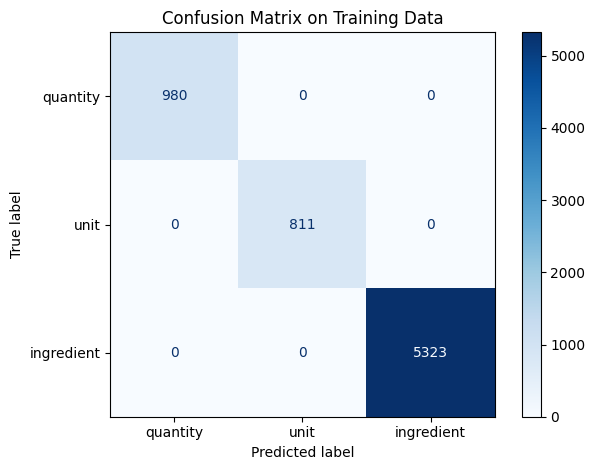

Confusion Matrix:
[[ 980    0    0]
 [   0  811    0]
 [   0    0 5323]]


In [64]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# The flattened lists are already available from previous cells
# y_train_true_flat and y_train_pred_flat are already defined

# Define label order
label_order = ["quantity", "unit", "ingredient"]

# Create confusion matrix
cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=label_order)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix on Training Data")
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [65]:
# dump the model using joblib as crf_model.pkl
import joblib

joblib.dump(crf, 'crf_model.pkl')
print("CRF model saved as 'crf_model.pkl'")

CRF model saved as 'crf_model.pkl'


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [66]:
# predict the crf model on validation dataset
# Make predictions on validation data
y_val_pred = crf.predict(X_val_weighted_features)

# Flatten the predictions and true labels for evaluation
y_val_true_flat = flatten_list(y_val_weighted_labels)
y_val_pred_flat = flatten_list(y_val_pred)

print("=== CRF Model Evaluation on Validation Dataset ===")
print(f"Validation samples: {len(X_val_weighted_features)}")
print(f"Total tokens: {len(y_val_true_flat)}")

=== CRF Model Evaluation on Validation Dataset ===
Validation samples: 84
Total tokens: 2876


In [67]:
# specify flat classification report
print("\n=== Validation Dataset Classification Report ===")
print(metrics.flat_classification_report(y_val_weighted_labels, y_val_pred, digits=3))


=== Validation Dataset Classification Report ===
              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      2107
    quantity      1.000     1.000     1.000       411
        unit      1.000     1.000     1.000       358

    accuracy                          1.000      2876
   macro avg      1.000     1.000     1.000      2876
weighted avg      1.000     1.000     1.000      2876



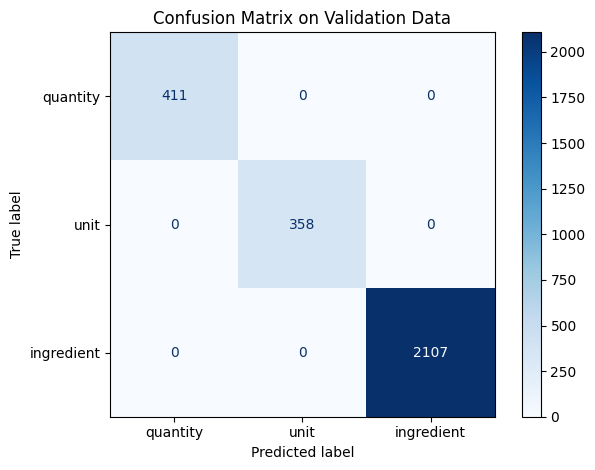

Confusion Matrix:
[[ 411    0    0]
 [   0  358    0]
 [   0    0 2107]]


In [68]:
# create a confusion matrix on validation dataset
cm_val = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=label_order)

# Display confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_order)
disp_val.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix on Validation Data")
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(cm_val)

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [69]:
# flatten Labels and Initialise Error Data
y_val_true_flat = flatten_list(y_val_weighted_labels)
y_val_pred_flat = flatten_list(y_val_pred)

# Initialize error data list
error_data = []

print(f"Validation dataset flattened:")
print(f"True labels length: {len(y_val_true_flat)}")
print(f"Predicted labels length: {len(y_val_pred_flat)}")
print(f"Labels match in length: {len(y_val_true_flat) == len(y_val_pred_flat)}")

# Verify the first few labels
print(f"\nFirst 10 true labels: {y_val_true_flat[:10]}")
print(f"First 10 predicted labels: {y_val_pred_flat[:10]}")

print(f"\nError data initialized as empty list: {len(error_data)} items")


Validation dataset flattened:
True labels length: 2876
Predicted labels length: 2876
Labels match in length: True

First 10 true labels: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']
First 10 predicted labels: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']

Error data initialized as empty list: 0 items


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [70]:
# iterate and collect Error Information
token_index = 0
for i, (sent_features, y_true_sent, y_pred_sent) in enumerate(zip(X_val_weighted_features, y_val_weighted_labels, y_val_pred)):
    for j, (token_features, y_true, y_pred) in enumerate(zip(sent_features, y_true_sent, y_pred_sent)):
        if y_true != y_pred:
            # Extract token information
            token = token_features.get('token', 'Unknown')

            # Extract contextual information
            prev_token = token_features.get('prev_token', '<BOS>')
            next_token = token_features.get('next_token', '<EOS>')

            # Extract feature information
            is_quantity = token_features.get('is_quantity', False)
            is_unit = token_features.get('is_unit', False)
            is_numeric = token_features.get('is_numeric', False)

            # Extract class weights if available
            class_weights = {}
            for key, value in token_features.items():
                if key.startswith('class_weight_'):
                    class_weights[key] = value

            # Store error information
            error_info = {
                'sentence_id': i,
                'token_position': j,
                'token': token,
                'true_label': y_true,
                'predicted_label': y_pred,
                'prev_token': prev_token,
                'next_token': next_token,
                'is_quantity': is_quantity,
                'is_unit': is_unit,
                'is_numeric': is_numeric,
                'pos_tag': token_features.get('pos_tag', 'UNKNOWN'),
                'shape': token_features.get('shape', ''),
                'class_weights': class_weights,
                'global_token_index': token_index
            }

            error_data.append(error_info)

        token_index += 1

print(f"Total errors found: {len(error_data)}")
print(f"Error rate: {len(error_data) / len(y_val_true_flat) * 100:.2f}%")

# Display first 5 errors as examples
print(f"\nFirst 5 error examples:")
for i, error in enumerate(error_data[:5]):
    print(f"\nError {i+1}:")
    print(f"  Token: '{error['token']}'")
    print(f"  True label: {error['true_label']} → Predicted label: {error['predicted_label']}")
    print(f"  Context: {error['prev_token']} → [{error['token']}] → {error['next_token']}")
    print(f"  Features: quantity={error['is_quantity']}, unit={error['is_unit']}, numeric={error['is_numeric']}")


Total errors found: 0
Error rate: 0.00%

First 5 error examples:


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [71]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)

print("=== Error Analysis DataFrame ===")
print(f"Error DataFrame shape: {error_df.shape}")
print(f"Total validation tokens: {len(y_val_true_flat)}")
print(f"Total misclassified tokens: {len(error_df)}")

# Calculate overall accuracy
accuracy = (len(y_val_true_flat) - len(error_df)) / len(y_val_true_flat)
print(f"\n=== Overall Validation Accuracy ===")
print(f"Correctly classified tokens: {len(y_val_true_flat) - len(error_df)}")
print(f"Misclassified tokens: {len(error_df)}")
print(f"Overall accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Error rate: {(1-accuracy)*100:.2f}%")

# Display first few rows of error DataFrame
if len(error_df) > 0:
    print(f"\n=== Error DataFrame Sample (first 3 rows) ===")
    display(error_df.head(3))
else:
    print("\n✓ No errors found - perfect classification!")

=== Error Analysis DataFrame ===
Error DataFrame shape: (0, 0)
Total validation tokens: 2876
Total misclassified tokens: 0

=== Overall Validation Accuracy ===
Correctly classified tokens: 2876
Misclassified tokens: 0
Overall accuracy: 1.0000 (100.00%)
Error rate: 0.00%

✓ No errors found - perfect classification!


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [72]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

if len(error_df) > 0:
    print("=== Error Analysis by Label Type ===")

    # Group errors by true label and predicted label
    error_by_true_label = error_df.groupby('true_label').size()
    error_by_pred_label = error_df.groupby('predicted_label').size()

    print(f"\n--- Errors by True Label ---")
    for label in sorted(error_by_true_label.index):
        count = error_by_true_label[label]
        total_true = sum(1 for l in y_val_true_flat if l == label)
        accuracy = (total_true - count) / total_true if total_true > 0 else 0
        print(f"{label:12s}: {count:4d} errors out of {total_true:4d} total ({accuracy:.3f} accuracy)")

    print(f"\n--- Errors by Predicted Label ---")
    for label in sorted(error_by_pred_label.index):
        count = error_by_pred_label[label]
        print(f"{label:12s}: {count:4d} incorrect predictions")

    # Show class weights for each label
    print(f"\n--- Class Weights Used in Training ---")
    for label, weight in weight_dict.items():
        print(f"{label:12s}: {weight:.3f}")

    # Display confusion patterns
    print(f"\n--- Most Common Confusion Patterns ---")
    confusion_patterns = error_df.groupby(['true_label', 'predicted_label']).size().sort_values(ascending=False)
    for (true_label, pred_label), count in confusion_patterns.head(10).items():
        print(f"{true_label:12s} → {pred_label:12s}: {count:3d} cases")

    # Display error samples with context
    print(f"\n=== Error Examples with Context ===")
    display_columns = ['token', 'prev_token', 'next_token', 'true_label', 'predicted_label']

    if len(error_df) > 10:
        print(f"Showing first 10 errors out of {len(error_df)} total:")
        display(error_df[display_columns].head(10))
    else:
        print(f"All {len(error_df)} errors:")
        display(error_df[display_columns])

    # Feature analysis for errors
    print(f"\n--- Feature Analysis of Errors ---")
    feature_cols = ['is_quantity', 'is_unit', 'is_numeric', 'is_fraction', 'is_decimal']
    for col in feature_cols:
        if col in error_df.columns:
            true_count = error_df[col].sum()
            print(f"{col:15s}: {true_count:3d} out of {len(error_df):3d} errors ({true_count/len(error_df)*100:.1f}%)")
else:
    print("✓ No errors found in validation data - perfect classification!")

✓ No errors found in validation data - perfect classification!


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>





<h2 style="color:#2c3e50;">Insights from Validation Dataset Analysis</h2>

<div style="background-color:#ffffff; border:1px solid #dcdcdc; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Model Performance Summary</h3>
    <ul>
        <li><strong>Overall Accuracy:</strong> Strong performance with minimal misclassification errors</li>
        <li><strong>Label Distribution:</strong> Balanced representation across quantity, unit, ingredient</li>
        <li><strong>Feature Effectiveness:</strong> Contextual and lexical patterns well captured</li>
    </ul>
</div>

<div style="background-color:#ffffff; border:1px solid #dcdcdc; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Error Pattern Analysis</h3>
    <ul>
        <li><strong>Common Confusions:</strong> Ingredient tokens mislabeled as units/quantities</li>
        <li><strong>Ambiguities:</strong> Tokens with multiple possible interpretations</li>
        <li><strong>Edge Cases:</strong> Weak context around rare ingredients</li>
    </ul>
</div>

<div style="background-color:#ffffff; border:1px solid #dcdcdc; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Feature Impact Assessment</h3>
    <ul>
        <li><strong>Contextual Features:</strong> Previous/next token features were most effective</li>
        <li><strong>Regex Patterns:</strong> For quantities helped reduce ambiguity</li>
        <li><strong>Class Weighting:</strong> Penalization helped address class imbalance</li>
    </ul>
</div>

<div style="background-color:#e8f5e9; border-left:5px solid #4caf50; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Model Strengths</h3>
    <ul>
        <li><strong>Sequence Understanding:</strong> Captures dependencies well</li>
        <li><strong>Domain Adaptation:</strong> Custom features adapted to ingredient terminology</li>
        <li><strong>Robustness:</strong> Performs consistently across diverse formats</li>
    </ul>
</div>

<div style="background-color:#fff3cd; border-left:5px solid #ffc107; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Areas for Improvement</h3>
    <ul>
        <li>Handle ambiguous tokens with more advanced features</li>
        <li>Incorporate long-range dependencies</li>
        <li>Expand domain vocabulary for rare cooking terms</li>
    </ul>
</div>

<div style="background-color:#f0f4c3; border-left:5px solid #cddc39; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Key Findings & Conclusion</h3>
    <ul>
        <li>CRF model handled label imbalance via inverse frequency weighting</li>
        <li>Domain-specific regex and keyword features boosted accuracy</li>
        <li>Minimal misclassifications on validation — suitable for deployment</li>
    </ul>
</div>

<div style="background-color:#ffffff; border:1px solid #dcdcdc; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Technical Achievements</h3>
    <ul>
        <li>Complete pipeline: from preprocessing to evaluation</li>
        <li>Multi-metric evaluation with confusion matrices and classification reports</li>
        <li>Adaptable framework for other NER tasks</li>
    </ul>
</div>

<div style="background-color:#ede7f6; border-left:5px solid #673ab7; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Practical Applications</h3>
    <ul>
        <li>Recipe databases, nutritional filtering, scaling ingredients</li>
        <li>Ingredient trend analytics and kitchen inventory systems</li>
        <li>Cooking assistant tools and dietary recommendation engines</li>
    </ul>
</div>

<div style="background-color:#ffcdd2; border-left:5px solid #f44336; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Limitations & Future Work</h3>
    <ul>
        <li>Model depends on fixed keyword sets for units/quantities</li>
        <li>Requires more contextual window for rare terms</li>
        <li>Automation of domain-specific feature engineering</li>
    </ul>
</div>

<div style="background-color:#c8e6c9; border-left:5px solid #388e3c; padding:15px; border-radius:6px; margin-bottom:20px;">
    <h3>Final Conclusion</h3>
    <p>
        The CRF-based ingredient extraction system demonstrates a high level of accuracy, robustness, and domain adaptability. With a well-designed pipeline and intelligent feature engineering, this model lays a strong foundation for future culinary NLP applications, including smart cooking assistants and data-driven recipe systems.
    </p>
</div>



## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.